In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

import torch
import torch.nn as nn
from torchvision.models import resnet50

import json

import torch.optim as optim

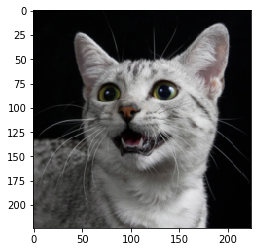

In [2]:
cat_img = Image.open("cat.png")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
cat_tensor = preprocess(cat_img)[None,:,:,:]

plt.imshow(cat_tensor[0].numpy().transpose(1,2,0))

In [3]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = resnet50(pretrained=True)
model.eval();

In [4]:
pred_original = model(norm(cat_tensor))

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred_original.max(dim=1)[1].item()])

Egyptian_cat


In [5]:
delta = torch.zeros_like(cat_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 3./255
for t in range(100):
    pred = model(norm(cat_tensor + delta))
    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([207]))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)   

In [6]:
max_class = pred.max(dim=1)[1].item()
print("Class: ", imagenet_classes[max_class])
print("Probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Class:  golden_retriever
Probability: 0.9611822962760925


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


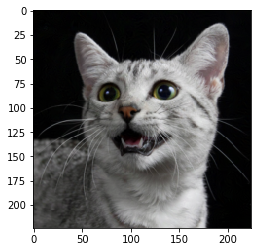

In [7]:
plt.imshow((cat_tensor + delta)[0].detach().numpy().transpose(1,2,0))

In [8]:
max_class_original = pred_original.max(dim=1)[1].item()
max_class_original

285

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


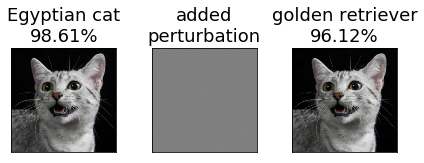

In [9]:
fig, ax = plt.subplots(1, 3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[0].imshow((cat_tensor)[0].detach().numpy().transpose(1,2,0))
gr = imagenet_classes[pred_original.max(dim=1)[1].item()].split("_")
ax[0].title.set_text('{}\n{}%'.format(" ".join(gr),  round(nn.Softmax(dim=1)(pred_original)[0,max_class_original].item()*100,2)) )


ax[1].imshow((delta+0.5)[0].detach().numpy().transpose(1,2,0))
ax[1].title.set_text('added\perturbation')

ax[2].imshow((cat_tensor + delta)[0].detach().numpy().transpose(1,2,0))
gr1 = imagenet_classes[max_class].split("_")
ax[2].title.set_text('{}\n{}%'.format(" ".join(gr1), round(nn.Softmax(dim=1)(pred)[0,max_class].item()*100,2)))

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.55)
ax[0].title.set_size(18)
ax[1].title.set_size(18)
ax[2].title.set_size(18)

plt.tight_layout()
plt.savefig("retriever_cat.png",bbox_inches = 'tight', dpi = 400)
plt.show()